In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn

ticker = "MSFT"
df = yf.download(ticker, period='60d', interval="2m")

df.columns = [i[0] for i in df.columns]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:


# Function to compute RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute MACD
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

# Compute Indicators
df["SMA_10"] = df["High"].rolling(window=10).mean()
df["EMA_10"] = df["High"].ewm(span=10, adjust=False).mean()
df["RSI_14"] = compute_rsi(df["High"], window=14)
df["MACD"], df["Signal_Line"] = compute_macd(df["High"])
df["BB_Mid"] = df["High"].rolling(window=20).mean()
df["BB_Std"] = df["High"].rolling(window=20).std()
df["BB_Upper"] = df["BB_Mid"] + (df["BB_Std"] * 2)
df["BB_Lower"] = df["BB_Mid"] - (df["BB_Std"] * 2)

price_volume = (df["High"] * df["Volume"]).rolling(window=20).sum().shift(1)
volume_sum = df["Volume"].rolling(window=20).sum().shift(1)
df["VWAP"] = price_volume / volume_sum


fib_window = 26  # adjust to match your feature engineering style

rolling_high = df["High"].rolling(window=fib_window).max().shift(1)
rolling_low = df["Low"].rolling(window=fib_window).min().shift(1)

df["Fib_23.6"] = rolling_low + 0.236 * (rolling_high - rolling_low)
df["Fib_38.2"] = rolling_low + 0.382 * (rolling_high - rolling_low)
df["Fib_61.8"] = rolling_low + 0.618 * (rolling_high - rolling_low)

df.drop(columns=["BB_Std"], inplace=True)

# Shift indicators to prevent data leakage

for col in ["SMA_10", "EMA_10", "RSI_14", "MACD", "Signal_Line", "VWAP", "BB_Mid", "BB_Upper", "BB_Lower"]:
    df[col] = df[col].shift(1)

# Drop NaN values resulting from rolling calculations
df.dropna(inplace=True)
  

In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# ---------- Environment ----------
class ContinuousTradingEnv(gym.Env):
    def __init__(self, df, initial_cash=1000, initial_stock=0, context_width=10, offset=1):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.initial_stock = initial_stock
        self.context_width = context_width
        self.offset = offset
        self.num_features = df.shape[1]

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.context_width, self.num_features + 2),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        self.current_step = self.context_width
        self.cash = self.initial_cash
        self.stock_held = self.initial_stock
        self.net_worths = []
        self.hold_duration = 0
        self.purchase_price = None 
        return self._get_obs(), {}


    def _get_obs(self):
        window = self.df.iloc[self.current_step - self.context_width:self.current_step].values.astype(np.float32)
        cash_stock = np.array([[self.cash, self.stock_held]] * self.context_width, dtype=np.float32)
        return np.concatenate((window, cash_stock), axis=1)

    def step(self, action):
        action = np.clip(action[0], -1, 1)
        terminated = False
        truncated = False
    
        current_price = self.df.iloc[self.current_step]["High"]
        prev_total_asset = self.cash + self.stock_held * current_price
    
        # --- Execute Action ---
        if action > 0:
            buy_amount = action * self.cash
            units_to_buy = int(buy_amount // current_price)
            if units_to_buy > 0:
                self.cash -= units_to_buy * current_price
                self.stock_held += units_to_buy
                self.purchase_price = current_price  # Store buy price
    
        elif action < 0:
            sell_fraction = -action
            units_to_sell = int(sell_fraction * self.stock_held)
            if units_to_sell > 0:
                self.cash += units_to_sell * current_price
                self.stock_held -= units_to_sell
                self.purchase_price = None  # Clear after sell
    
        # --- Advance Step ---
        self.current_step += 1
        if self.current_step + self.offset >= len(self.df):
            terminated = True
            self.current_step = len(self.df) - 1
    
        # --- Compute Reward ---
        current_total_asset = self.cash + self.stock_held * self.df.iloc[self.current_step]["High"]
        reward = current_total_asset - prev_total_asset
        self.net_worths.append(current_total_asset)
    
        return self._get_obs(), reward, terminated, truncated, {}


    def render(self, mode="human"):
        if self.current_step >= len(self.df):
            print("End of data.")
            return
    
        current_price = self.df.iloc[self.current_step]["Close"]
        total_asset = self.cash + self.stock_held * current_price
    
        # Compute profit relative to initial starting state
        initial_price = self.df.iloc[self.context_width]["Close"]
        starting_value = self.initial_cash + self.initial_stock * initial_price
        profit = total_asset - starting_value
        status = "PROFIT" if profit > 0 else "LOSS" if profit < 0 else "BREAKEVEN"
    
        print(
            f"Step: {self.current_step:4d} | "
            f"Price: {current_price:7.2f} | "
            f"Cash: {self.cash:7.2f} | "
            f"Stock Held: {self.stock_held:3d} | "
            f"Net Worth: {total_asset:8.2f} | "
            f"PnL: {profit:+.2f} ({status})"
        )
    
        # Optional: Show when stop loss would trigger
        if self.stock_held > 0 and self.purchase_price:
            current_atr = self.df.iloc[self.current_step].get("ATR_14", np.nan)
            if not np.isnan(current_atr):
                stop_price = self.purchase_price - 1.5 * current_atr
                if current_price <= stop_price:
                    print(f"[STOP LOSS] Would trigger at {stop_price:.2f} | Current Price: {current_price:.2f}")






# ---------- Split ----------
context_width = 10
offset = 1
split_point = int(len(df) * 0.7)
train_df = df[:split_point]
test_df = df[split_point:]





In [9]:
# ---------- Training ----------
train_env = DummyVecEnv([lambda: ContinuousTradingEnv(train_df, context_width=context_width, offset=offset)])
model = PPO("MlpPolicy", train_env, verbose=1, device='cpu')
model.learn(total_timesteps=1_000_000)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 636  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 380          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0015395547 |
|    clip_fraction        | 0.00225      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -0.0367      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.36         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00143     |
|    std                  | 0.991        |
|    value_loss           | 3.59         |

In [10]:
# ---------- Evaluation ----------
test_env = ContinuousTradingEnv(test_df, context_width=10, offset=1)
obs, _ = test_env.reset()
done = False

actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    actions.append(action[0])  # extract float
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)

    test_env.render()

Step:   11 | Price:  372.27 | Cash: 1000.00 | Stock Held:   0 | Net Worth:  1000.00 | PnL: +0.00 (BREAKEVEN)
Step:   12 | Price:  372.12 | Cash: 1000.00 | Stock Held:   0 | Net Worth:  1000.00 | PnL: +0.00 (BREAKEVEN)
Step:   13 | Price:  371.67 | Cash: 1000.00 | Stock Held:   0 | Net Worth:  1000.00 | PnL: +0.00 (BREAKEVEN)
Step:   14 | Price:  371.51 | Cash: 1000.00 | Stock Held:   0 | Net Worth:  1000.00 | PnL: +0.00 (BREAKEVEN)
Step:   15 | Price:  371.70 | Cash: 1000.00 | Stock Held:   0 | Net Worth:  1000.00 | PnL: +0.00 (BREAKEVEN)
Step:   16 | Price:  371.58 | Cash: 1000.00 | Stock Held:   0 | Net Worth:  1000.00 | PnL: +0.00 (BREAKEVEN)
Step:   17 | Price:  371.62 | Cash: 1000.00 | Stock Held:   0 | Net Worth:  1000.00 | PnL: +0.00 (BREAKEVEN)
Step:   18 | Price:  371.66 | Cash: 1000.00 | Stock Held:   0 | Net Worth:  1000.00 | PnL: +0.00 (BREAKEVEN)
Step:   19 | Price:  371.83 | Cash: 1000.00 | Stock Held:   0 | Net Worth:  1000.00 | PnL: +0.00 (BREAKEVEN)
Step:   20 | Price:

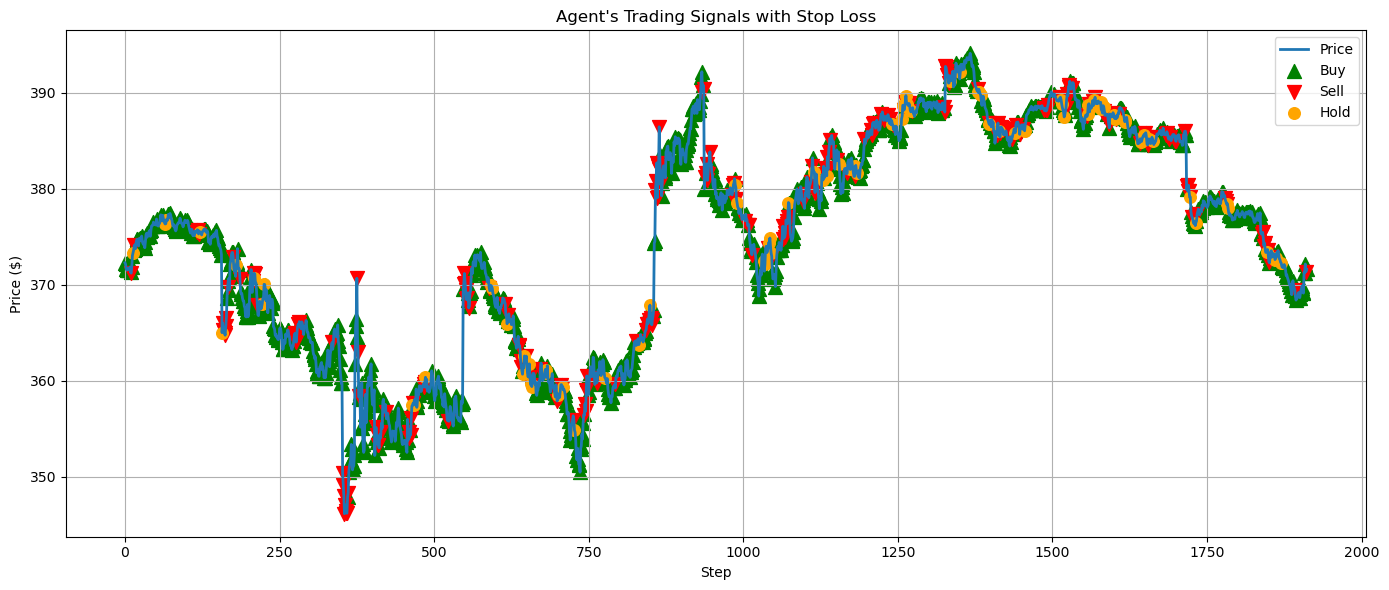

In [11]:


# ---------- Plot Trading Signals ----------
buy_indices = [i for i, a in enumerate(actions) if a > 0.1]
sell_indices = [i for i, a in enumerate(actions) if a < -0.1]
hold_indices = [i for i, a in enumerate(actions) if -0.1 <= a <= 0.1]
# stop_loss_indices = [i for i, step in enumerate(test_env.stop_loss_steps) if step < len(prices)]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='green', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='red', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='o', color='orange', s=70, label='Hold')
# plt.scatter(stop_loss_indices, [prices[i] for i in stop_loss_indices], marker='x', color='black', s=100, label='Stop Loss')
plt.title("Agent's Trading Signals with Stop Loss")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


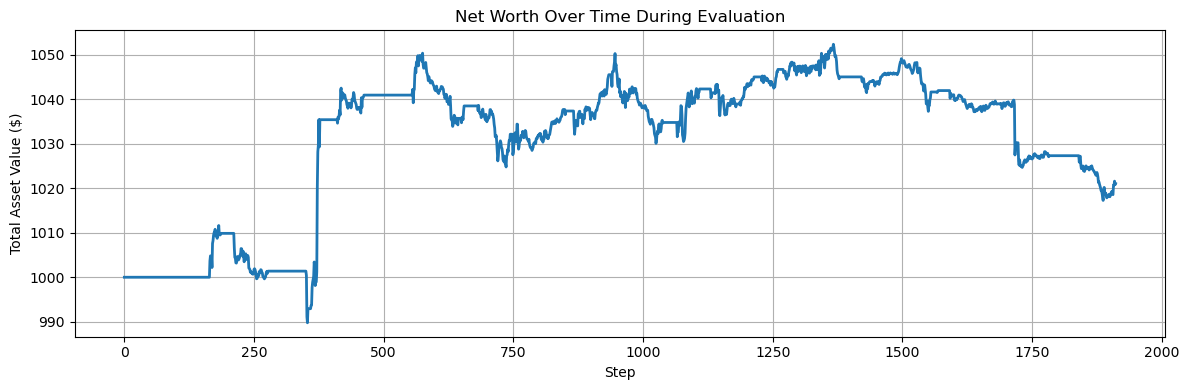

In [12]:

# ---------- Plot Net Worth ----------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()